# Import necessary libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import re
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from nltk.stem import WordNetLemmatizer, PorterStemmer






# Load the dataset

In [5]:
df = pd.read_csv(r'C:\Users\venka\OneDrive\Desktop\infosys project\cyberbullying_tweets.csv')


In [6]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: count, dtype: int64

In [7]:
# checking null values
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [8]:
df.describe()

,tweet_text,cyberbullying_type
count,39869,39869
unique,39774,5
top,"raped is not a synonym for ""touched"" @magconbo...",religion
freq,2,7998


In [9]:
df.shape

(39869, 2)

In [10]:
df.value_counts

<bound method DataFrame.value_counts of                                               tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[39869 rows x 2 columns]>

In [11]:
category_counts = df['cyberbullying_type'].value_counts()

# Display the counts
print(category_counts)

cyberbullying_type
religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: count, dtype: int64


# Data preprocessing and Data visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


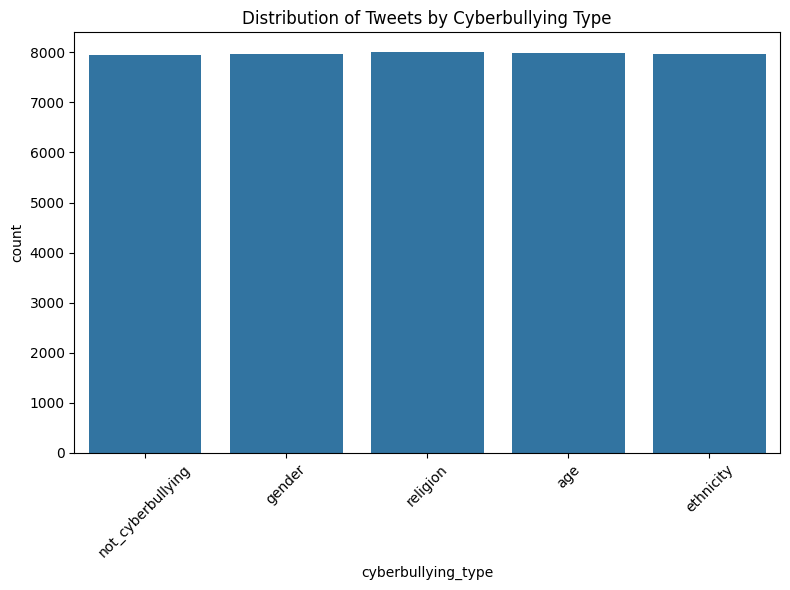

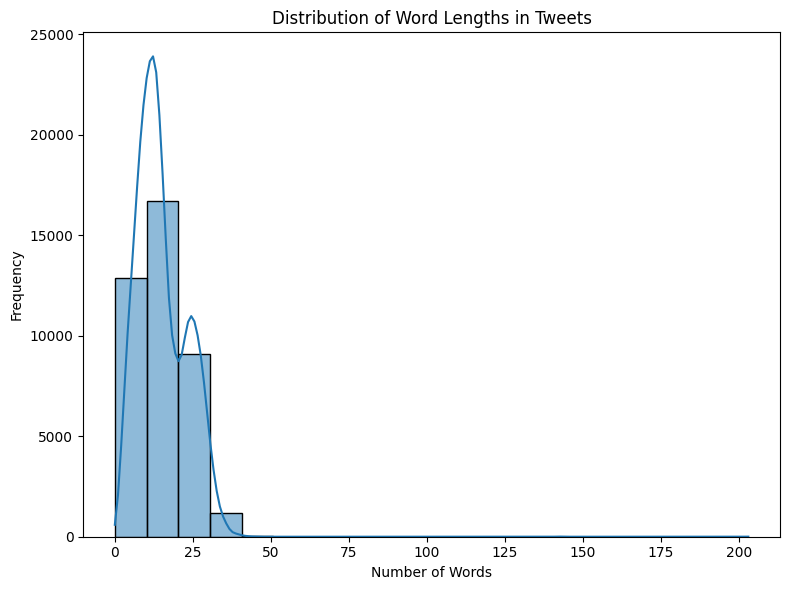

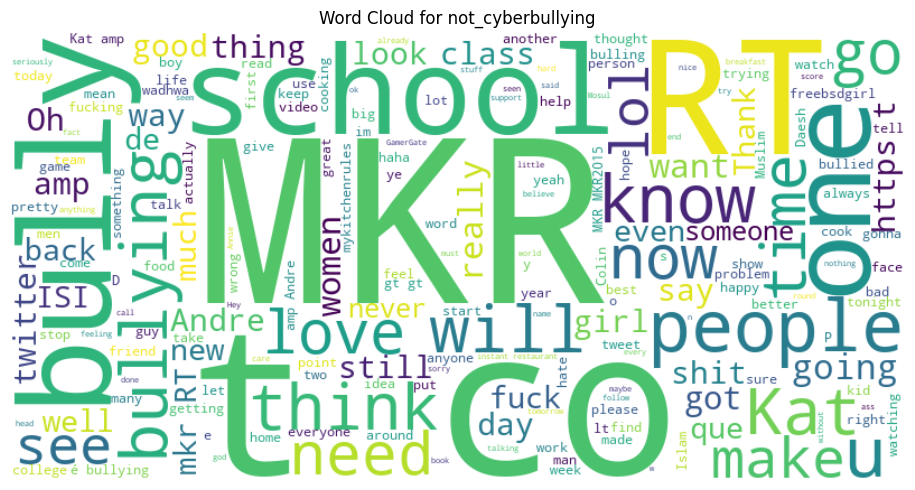

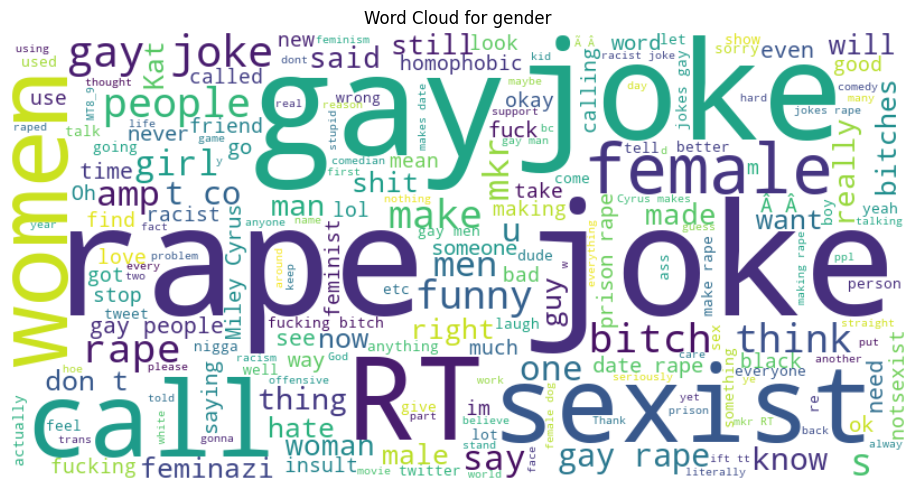

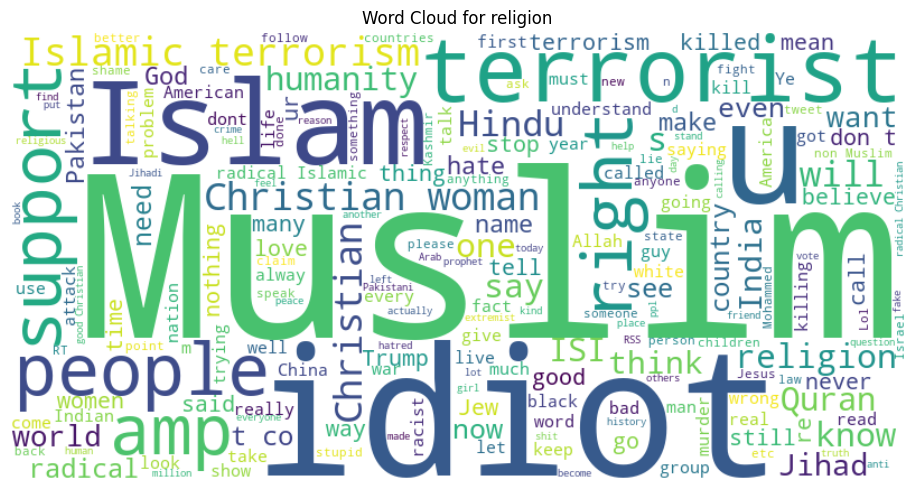

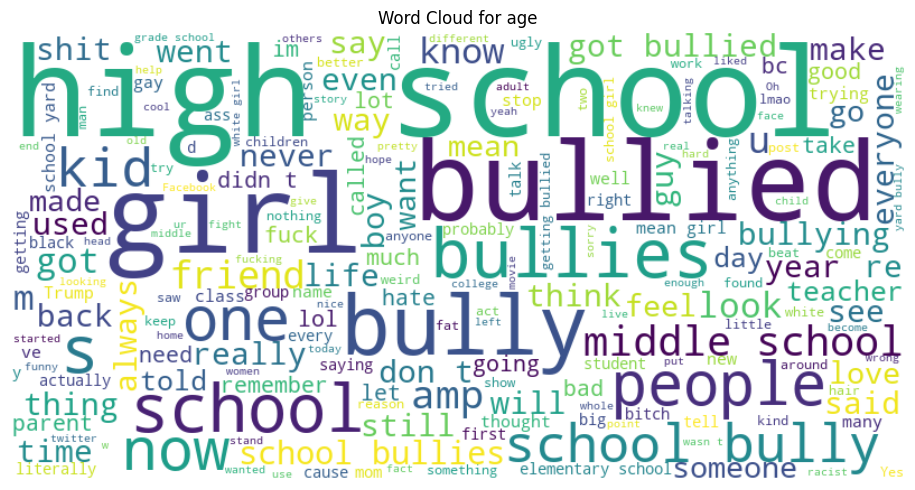

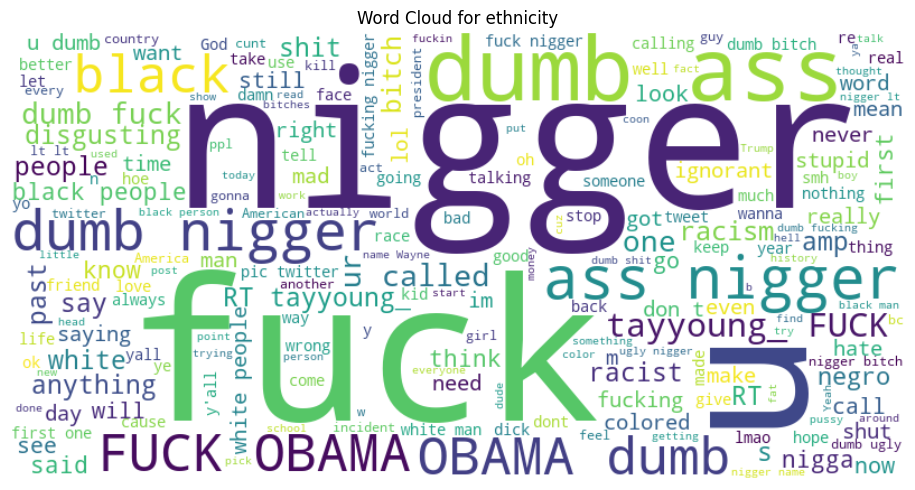

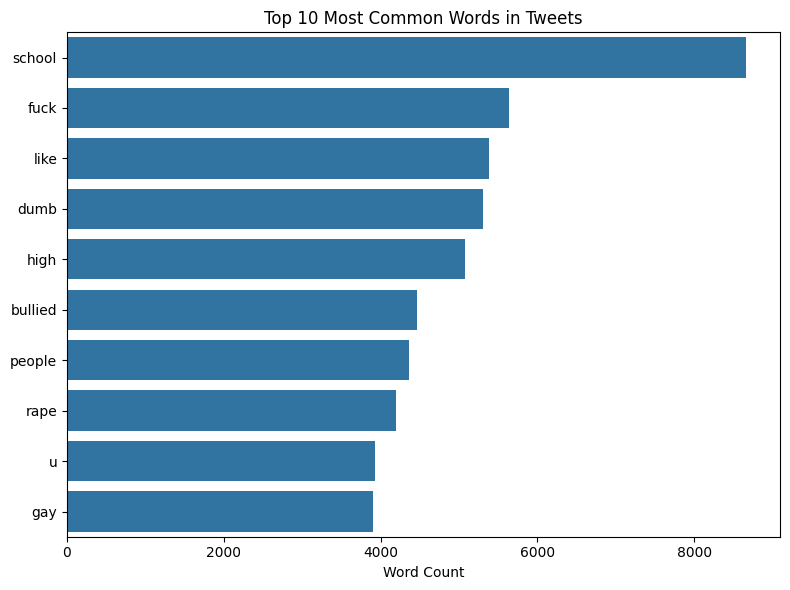

In [12]:


# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to preprocess text (remove stopwords, punctuation, etc.)
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = text.split()  # Split into words
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

# Preprocess the 'tweet_text' column for word-based analysis
df['processed_text'] = df['tweet_text'].apply(preprocess_text)

# Task 1: Plot the distribution of tweets labeled by type of cyberbullying
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='cyberbullying_type')
plt.title('Distribution of Tweets by Cyberbullying Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 2: Plot distribution of word lengths in the tweets
df['word_count'] = df['processed_text'].apply(len)
plt.figure(figsize=(8,6))
sns.histplot(df['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Lengths in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Task 3: Plot word clouds for different cyberbullying types
for label in df['cyberbullying_type'].unique():
    text = ' '.join(df[df['cyberbullying_type'] == label]['tweet_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Task 4: Bar charts of common words
all_words = [word for text in df['processed_text'] for word in text]
word_freq = Counter(all_words).most_common(10)

words, counts = zip(*word_freq)
plt.figure(figsize=(8,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 10 Most Common Words in Tweets')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()


In [13]:
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

In [18]:
# Encode target labels
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['cyberbullying_type'])

# Ensure 'cleaned_text' contains only strings
df['cleaned_text'] = df['cleaned_text'].fillna("").astype(str)

# Feature Extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),  # Includes unigrams and bigrams
    analyzer='word'
)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['encoded_labels']



# Split data into train and test sets

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Define models to evaluate

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


# Evaluate each model


Logistic Regression - Classification Report:
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1598
        ethnicity       0.98      0.97      0.97      1592
           gender       0.93      0.87      0.90      1595
not_cyberbullying       0.81      0.89      0.84      1589
         religion       0.96      0.95      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.93      0.93      7974


Random Forest - Classification Report:
                   precision    recall  f1-score   support

              age       0.98      0.97      0.98      1598
        ethnicity       0.98      0.98      0.98      1592
           gender       0.93      0.88      0.91      1595
not_cyberbullying       0.83      0.88      0.85      1589
         religion       0.95      0.96      0.96      1600

         accuracy       

C:\Users\venka\AppData\Local\Temp\ipykernel_33352\1739908378.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1-Score", data=results_df.sort_values(by="F1-Score", ascending=False), palette="viridis")


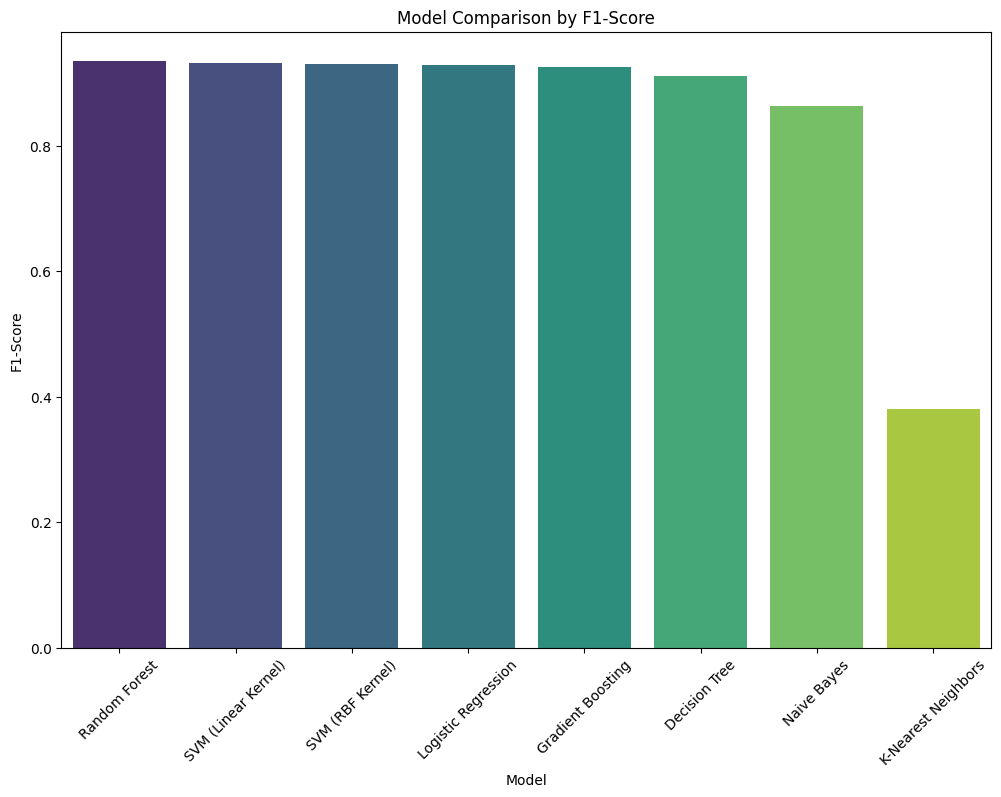

In [21]:
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    # Print classification report for each model
    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nComparison of Model Performance:")
print(results_df)

# Plot the results for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="F1-Score", data=results_df.sort_values(by="F1-Score", ascending=False), palette="viridis")
plt.title("Model Comparison by F1-Score")
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.show()

# Hyper parametric tuning

In [22]:
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
rf_grid_search.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:")
print(rf_grid_search.best_params_)

# Evaluate on test data
rf_best = rf_grid_search.best_estimator_
rf_y_pred = rf_best.predict(X_test)

print("\nRandom Forest - Tuned Model Report:")
print(classification_report(y_test, rf_y_pred, target_names=label_encoder.classes_))


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest - Tuned Model Report:
                   precision    recall  f1-score   support

              age       0.98      0.97      0.98      1598
        ethnicity       0.98      0.98      0.98      1592
           gender       0.93      0.88      0.91      1595
not_cyberbullying       0.83      0.88      0.85      1589
         religion       0.95      0.96      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.94      0.93      0.94      7974
     weighted avg       0.94      0.93      0.94      7974



In [23]:
# Define parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=500, random_state=42),
    param_grid=lr_param_grid,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
lr_grid_search.fit(X_train, y_train)

print("\nBest Parameters for Logistic Regression:")
print(lr_grid_search.best_params_)

# Evaluate on test data
lr_best = lr_grid_search.best_estimator_
lr_y_pred = lr_best.predict(X_test)

print("\nLogistic Regression - Tuned Model Report:")
print(classification_report(y_test, lr_y_pred, target_names=label_encoder.classes_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters for Logistic Regression:
{'C': 1, 'solver': 'lbfgs'}

Logistic Regression - Tuned Model Report:
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1598
        ethnicity       0.98      0.97      0.97      1592
           gender       0.93      0.87      0.90      1595
not_cyberbullying       0.81      0.89      0.84      1589
         religion       0.96      0.95      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.93      0.93      7974




Logistic Regression - Classification Report:
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1598
        ethnicity       0.98      0.97      0.97      1592
           gender       0.93      0.87      0.90      1595
not_cyberbullying       0.81      0.89      0.84      1589
         religion       0.96      0.95      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.93      0.93      7974



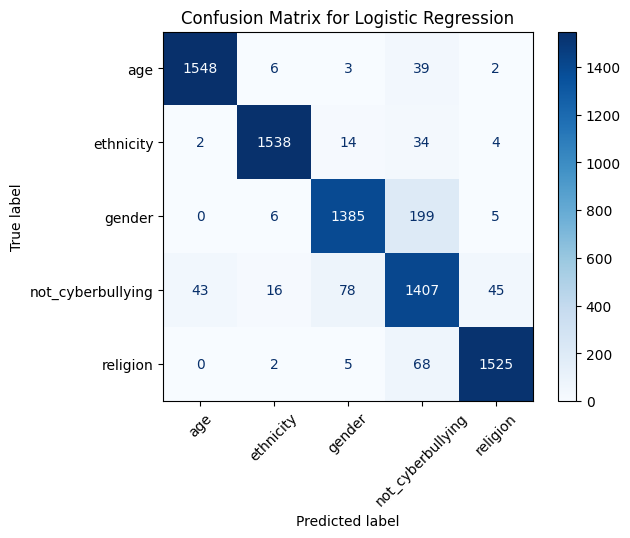


Random Forest - Classification Report:
                   precision    recall  f1-score   support

              age       0.98      0.97      0.98      1598
        ethnicity       0.98      0.98      0.98      1592
           gender       0.93      0.88      0.91      1595
not_cyberbullying       0.83      0.88      0.85      1589
         religion       0.95      0.96      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.94      0.93      0.94      7974
     weighted avg       0.94      0.93      0.94      7974



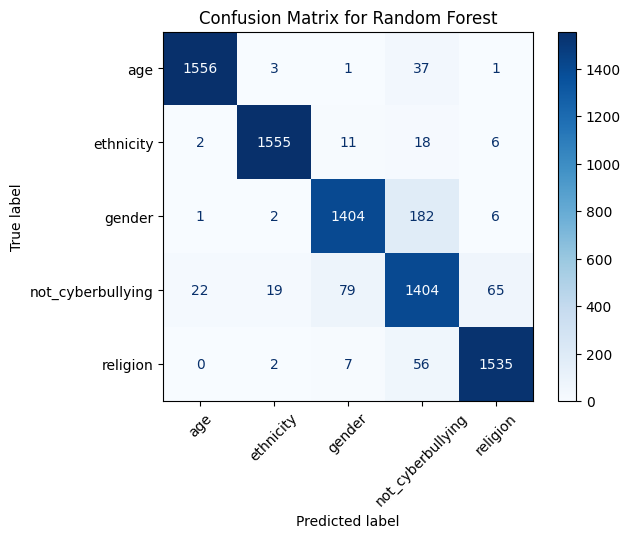


Naive Bayes - Classification Report:
                   precision    recall  f1-score   support

              age       0.87      0.98      0.92      1598
        ethnicity       0.94      0.90      0.92      1592
           gender       0.90      0.84      0.87      1595
not_cyberbullying       0.80      0.65      0.71      1589
         religion       0.82      0.98      0.89      1600

         accuracy                           0.87      7974
        macro avg       0.87      0.87      0.86      7974
     weighted avg       0.87      0.87      0.86      7974



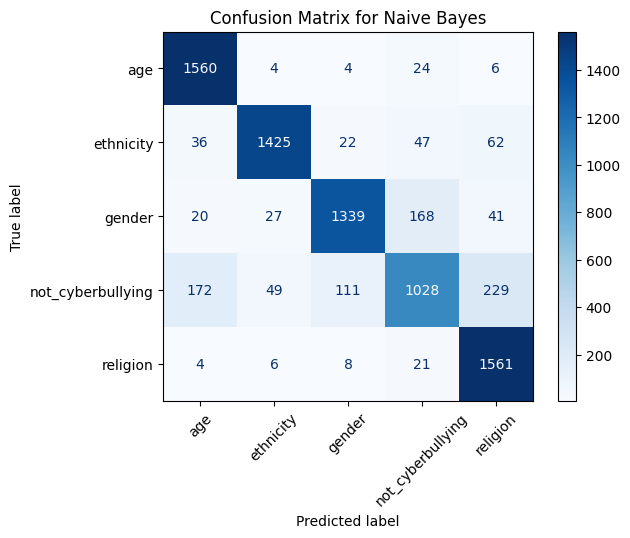


SVM (Linear Kernel) - Classification Report:
                   precision    recall  f1-score   support

              age       0.96      0.98      0.97      1598
        ethnicity       0.97      0.98      0.98      1592
           gender       0.94      0.87      0.90      1595
not_cyberbullying       0.83      0.88      0.86      1589
         religion       0.96      0.95      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.93      0.93      7974



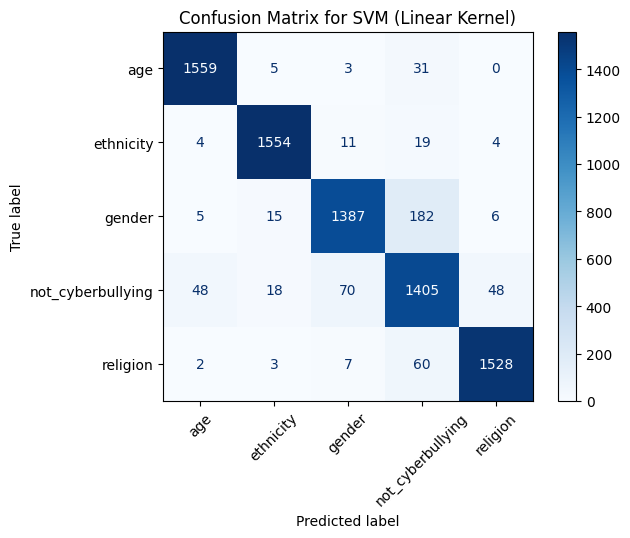


SVM (RBF Kernel) - Classification Report:
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1598
        ethnicity       0.97      0.97      0.97      1592
           gender       0.95      0.85      0.90      1595
not_cyberbullying       0.81      0.90      0.85      1589
         religion       0.97      0.95      0.96      1600

         accuracy                           0.93      7974
        macro avg       0.93      0.93      0.93      7974
     weighted avg       0.93      0.93      0.93      7974



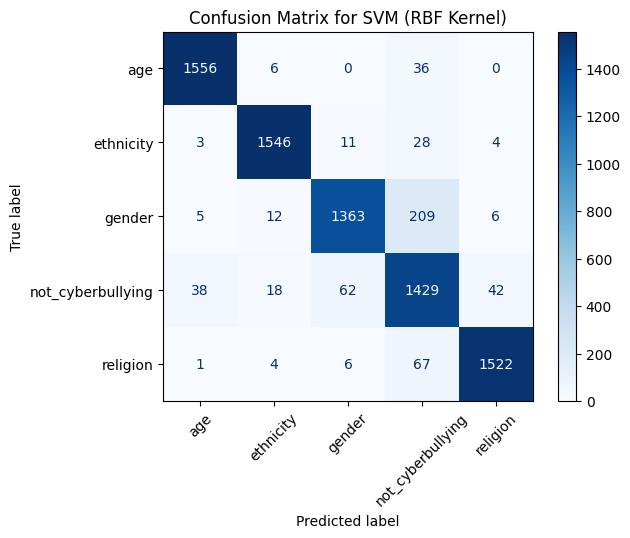


K-Nearest Neighbors - Classification Report:
                   precision    recall  f1-score   support

              age       0.96      0.24      0.39      1598
        ethnicity       0.96      0.37      0.54      1592
           gender       0.62      0.31      0.42      1595
not_cyberbullying       0.25      0.92      0.39      1589
         religion       0.90      0.10      0.17      1600

         accuracy                           0.39      7974
        macro avg       0.74      0.39      0.38      7974
     weighted avg       0.74      0.39      0.38      7974



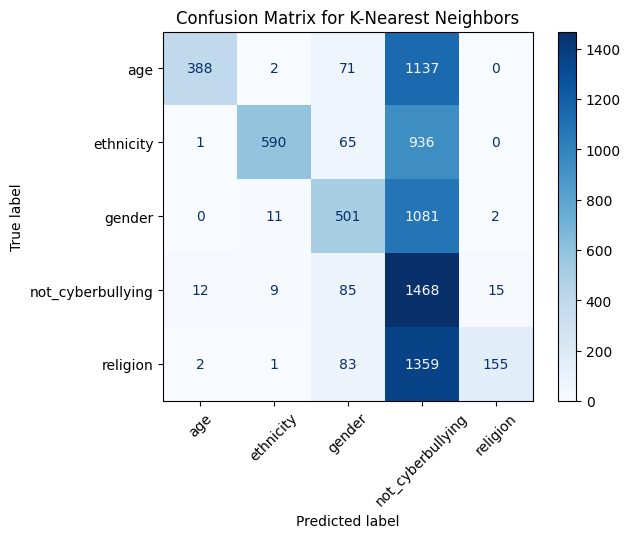


Decision Tree - Classification Report:
                   precision    recall  f1-score   support

              age       0.97      0.96      0.97      1598
        ethnicity       0.96      0.97      0.97      1592
           gender       0.87      0.87      0.87      1595
not_cyberbullying       0.82      0.81      0.81      1589
         religion       0.93      0.94      0.94      1600

         accuracy                           0.91      7974
        macro avg       0.91      0.91      0.91      7974
     weighted avg       0.91      0.91      0.91      7974



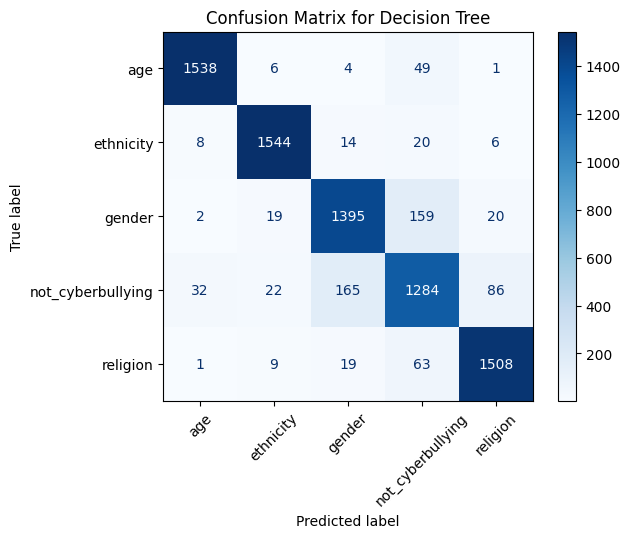


Gradient Boosting - Classification Report:
                   precision    recall  f1-score   support

              age       0.97      0.97      0.97      1598
        ethnicity       0.98      0.97      0.97      1592
           gender       0.96      0.84      0.89      1595
not_cyberbullying       0.78      0.91      0.84      1589
         religion       0.97      0.94      0.95      1600

         accuracy                           0.92      7974
        macro avg       0.93      0.92      0.93      7974
     weighted avg       0.93      0.92      0.93      7974



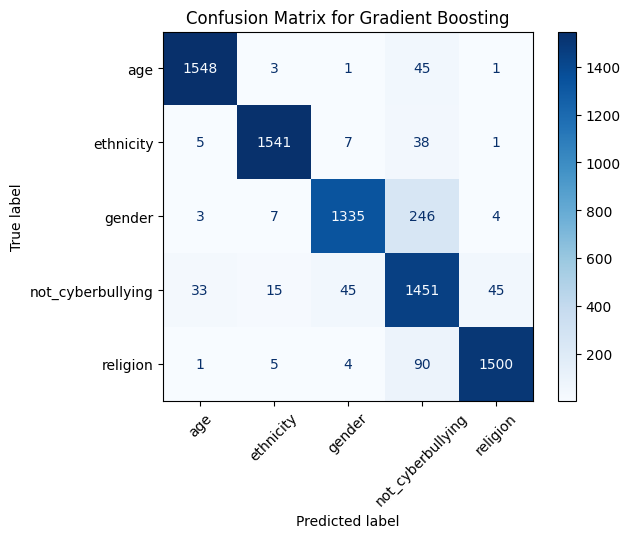


Comparison of Model Performance:
                  Model  Accuracy  Precision    Recall  F1-Score
0   Logistic Regression  0.928392   0.931160  0.928392  0.929150
1         Random Forest  0.934788   0.936388  0.934788  0.935229
2           Naive Bayes  0.866943   0.867208  0.866943  0.863225
3   SVM (Linear Kernel)  0.932155   0.933619  0.932155  0.932429
4      SVM (RBF Kernel)  0.930023   0.933202  0.930023  0.930652
5   K-Nearest Neighbors  0.389014   0.739318  0.389014  0.380459
6         Decision Tree  0.911588   0.911456  0.911588  0.911504
7     Gradient Boosting  0.924881   0.931455  0.924881  0.926172
8   Logistic Regression  0.928392   0.931160  0.928392  0.929150
9         Random Forest  0.934788   0.936388  0.934788  0.935229
10          Naive Bayes  0.866943   0.867208  0.866943  0.863225
11  SVM (Linear Kernel)  0.932155   0.933619  0.932155  0.932429
12     SVM (RBF Kernel)  0.930023   0.933202  0.930023  0.930652
13  K-Nearest Neighbors  0.389014   0.739318  0.389014  

C:\Users\venka\AppData\Local\Temp\ipykernel_33352\2016237219.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1-Score", data=results_df.sort_values(by="F1-Score", ascending=False), palette="viridis")


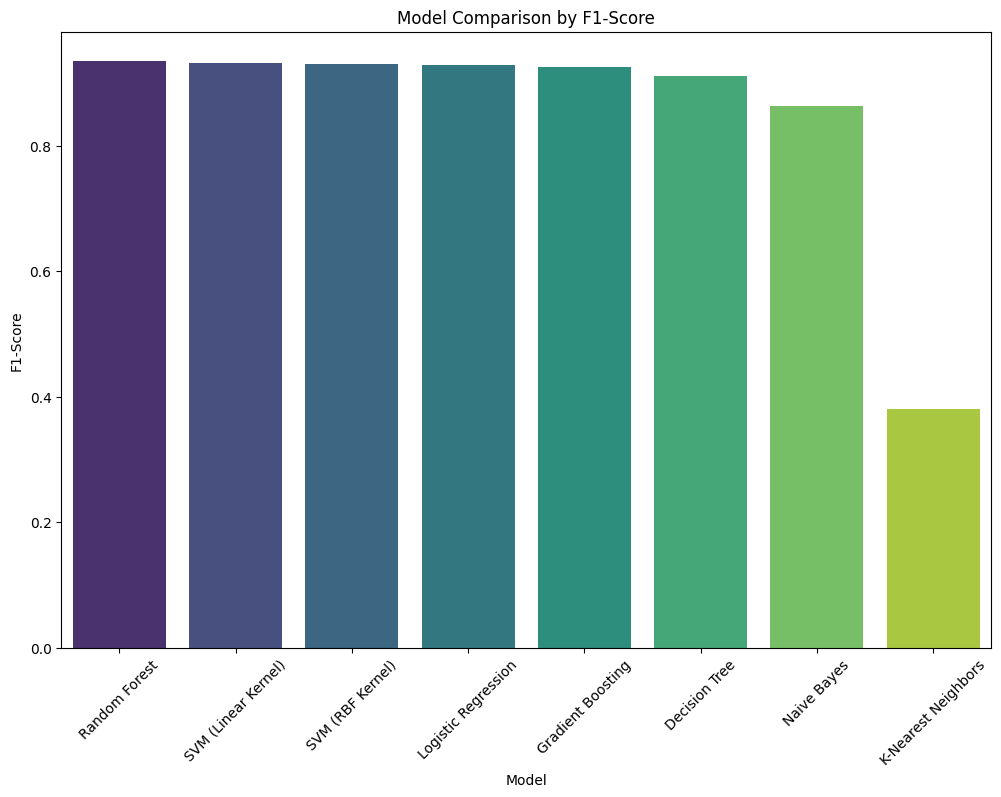

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Evaluate each model and plot confusion matrix
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    # Print classification report
    print(f"\n{name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, name)

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nComparison of Model Performance:")
print(results_df)

# Plot the results for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="F1-Score", data=results_df.sort_values(by="F1-Score", ascending=False), palette="viridis")
plt.title("Model Comparison by F1-Score")
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.show()
